In [1]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np 
import pandas as pd
import os 
import sklearn

In [2]:
DATASET_PATH = ".\dataset"
print(os.listdir(DATASET_PATH))

['hood', 'shirt', 'sleeveless', 'sweater', 'sweatshirt', 't-shirt']


In [3]:
categories = []
filenames = []
images = []

df = pd.DataFrame(columns=['category', 'filename', 'image'])
for folder in os.listdir(DATASET_PATH):    
    for file in os.listdir(os.path.join(DATASET_PATH, folder)):
        categories.append(folder)  
        filenames.append(file)
        images.append(os.path.join(DATASET_PATH, folder, file))

df['category'] = categories
df['filename'] = filenames
df['image'] = images

df = df.iloc[np.random.permutation(df.index)].reset_index(drop=True)

In [5]:
df.head(10)

,category,filename,image
0,shirt,96.jpg,.\dataset\shirt\96.jpg
1,t-shirt,217.jpg,.\dataset\t-shirt\217.jpg
2,sleeveless,139.jpg,.\dataset\sleeveless\139.jpg
3,sweatshirt,118.jpg,.\dataset\sweatshirt\118.jpg
4,sweater,267.jpg,.\dataset\sweater\267.jpg
5,hood,425.jpg,.\dataset\hood\425.jpg
6,hood,357.jpg,.\dataset\hood\357.jpg
7,hood,494.jpg,.\dataset\hood\494.jpg
8,t-shirt,319.jpg,.\dataset\t-shirt\319.jpg
9,shirt,135.jpg,.\dataset\shirt\135.jpg


In [6]:
len(df)

2900

In [7]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [8]:
# 딕셔너리 데이터를 인자값을 받아서 이미지를 출력한다.
def plot_figures(figures, nrows = 1, ncols=1,figsize=(5, 3)):    
    fig, axeslist = plt.subplots(ncols=ncols, nrows=nrows, figsize=figsize)
    for ind,title in enumerate(figures):
        axeslist.ravel()[ind].imshow(cv2.cvtColor(figures[title], cv2.COLOR_BGR2RGB))
        axeslist.ravel()[ind].set_title(title)
        axeslist.ravel()[ind].set_axis_off()
    plt.tight_layout()

In [98]:
# 이미지 경로를 읽어서 numpy로 변환한다.
# 기본 0.1 비율로 리사이즈를 처리한다.
def load_image(img_path, resized_fac = 1):
    img  = cv2.imread(img_path)
    w, h, _ = img.shape
    resized = cv2.resize(img, (int(h*resized_fac), int(w*resized_fac)), interpolation = cv2.INTER_AREA)
    return resized

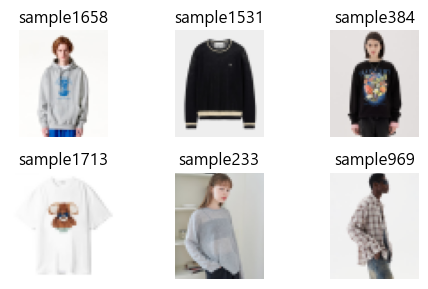

In [10]:
figures = {'sample'+str(i) : load_image(row.image) for i, row in df.sample(6).iterrows()}
figures.keys()
plot_figures(figures, 2, 3)


<Axes: ylabel='category'>

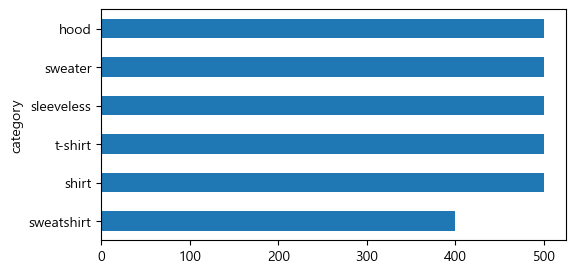

In [11]:
# 막대 그래프로 타입별로 갯수 출력
plt.figure(figsize=(6, 3))
df.category.value_counts().sort_values().plot(kind='barh')

In [12]:
import tensorflow as tf
import keras
from keras import Model
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.layers import GlobalMaxPooling2D
print(tf.__version__)
print(keras.__version__)


2.15.1
2.15.0


In [13]:
# !pip install --upgrade t/ensorflow==2.15.1

In [14]:
# 입력 이미지
img_width, img_height, img_channel = 224, 224, 3

# 훈련된 모델 사용
base_model = ResNet50(weights='imagenet', include_top=False, input_shape = (img_width, img_height, img_channel))
base_model.trainable = False

model = keras.Sequential([
    base_model,
    GlobalMaxPooling2D()
])

model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_max_pooling2d (Glob  (None, 2048)              0         
 alMaxPooling2D)                                                 
                                                                 
Total params: 23587712 (89.98 MB)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


In [15]:
def get_embedding(model, img_path):
    # Pillow 이미지 로드
    img = image.load_img(img_path, target_size=(img_width, img_height))
    # numpy 데이터로 변환 (224, 224, 3)
    x = image.img_to_array(img)
    # 차원을 추가해준다. (1, 224, 224, 3)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    # 1차원의 배열로 재배열해준다. [[5.232, 2.12, ...]] -> [5.232, 2.12, ...]
    return model.predict(x).reshape(-1)

In [16]:
# 첫 행 이미지 임베딩을 출력
emb = get_embedding(model, df.iloc[0].image)
emb.shape

1/1 [==============================] - 2s 2s/step


(2048,)

In [26]:
df.iloc[0].image

'.\\dataset\\shirt\\96.jpg'

(60, 50, 3)
[ 5.832027  17.973116   2.0212219 ...  3.641172   7.0549273 11.857157 ]


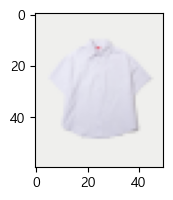

In [17]:
# 첫 행 이미지 시각화
img_array = load_image(df.iloc[0].image)
plt.figure(figsize = (2,2))
plt.imshow(cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB))
print(img_array.shape)
print(emb)


In [18]:
%%time

# 전체 데이터 임베딩
df_sample = df
map_embeddings = df_sample['image'].apply(lambda img: get_embedding(model, img))
df_embs = map_embeddings.apply(pd.Series)

print(df_embs.shape)
df_embs.head()

1/1 [==============================] - 0s 224ms/step
(2900, 2048)
CPU times: total: 11min 43s
Wall time: 16min 8s


,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,5.832027,17.973116,2.021222,0.846399,4.176826,0.976126,3.296373,4.149473,0.189918,0.000000,...,4.269410,2.489546,0.032514,0.407614,2.434266,0.000000,1.056733,3.641172,7.054927,11.857157
1,1.726173,18.319046,1.867756,0.453993,1.787264,0.000000,10.187489,6.143237,0.261909,0.502557,...,1.910964,1.201503,1.282612,14.432741,2.676788,1.552559,6.834966,2.143767,0.000000,14.154542
2,4.107688,3.559958,0.000000,9.032554,1.031520,0.000000,1.585233,2.692248,5.458540,2.339971,...,2.960621,2.190386,1.807232,11.519424,0.851114,0.000000,2.900753,12.821202,2.792721,2.582162
3,7.332390,14.160936,1.692524,0.228865,3.005590,3.396730,1.111790,1.026416,1.675258,1.653035,...,4.295385,5.092620,3.460793,25.140669,0.932124,1.682749,2.523114,0.689133,0.000000,4.955785
4,5.905716,8.569823,0.000000,3.668726,1.214940,2.281629,2.212019,3.321763,3.970232,2.421467,...,2.223633,0.775152,3.284800,19.593323,3.784632,0.000000,7.058646,7.479707,0.000000,8.153091


In [19]:
df_embs.shape

(2900, 2048)

In [20]:
from sklearn.metrics.pairwise import pairwise_distances

# cosine 거리 계산
pairwise_distances(df_embs, metric='cosine')

# 정규화
cosine_sim = 1 - pairwise_distances(df_embs, metric='cosine')
cosine_sim[:4, :4]

array([[0.99999946, 0.6199594 , 0.5516245 , 0.5758186 ],
       [0.6199594 , 0.99999976, 0.6337676 , 0.6472562 ],
       [0.5516245 , 0.6337676 , 0.9999999 , 0.59359336],
       [0.5758186 , 0.6472562 , 0.59359336, 0.9999987 ]], dtype=float32)

In [48]:
indices = pd.Series(range(len(df)), index=df.index)

def get_recommender(idx, df, top_n = 5):
    sim_idx = indices[idx]
    sim_scores = list(enumerate(cosine_sim[sim_idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:top_n+1]
    idx_rec    = [i[0] for i in sim_scores]
    idx_sim    = [i[1] for i in sim_scores]
    
    return indices.iloc[idx_rec].index, idx_sim

In [45]:
def get_recommender_for_external(external_emb, df, top_n=5):
    # 외부 데이터 포인트를 df의 임베딩과 비교하기 위해 코사인 유사도 계산
    sim_scores = list(enumerate(1 - pairwise_distances([external_emb], df_embs, metric='cosine')[0]))
    
    # 유사도 점수를 내림차순으로 정렬
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    # 상위 N개의 유사한 인덱스와 점수 선택
    idx_rec = [i[0] for i in sim_scores[:top_n]]
    idx_sim = [i[1] for i in sim_scores[:top_n]]
    
    return df.index[idx_rec], idx_sim

In [53]:
get_recommender_for_external(test_img, df, top_n = 10)

(Index([140, 2098, 842, 1181, 2838, 2092, 2367, 2792, 1754, 402], dtype='int64'),
 [0.7895315,
  0.7761969,
  0.76179206,
  0.75681406,
  0.7540897,
  0.75399315,
  0.753217,
  0.7504978,
  0.7500118,
  0.74823207])

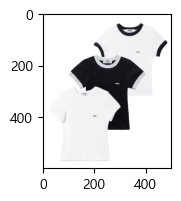

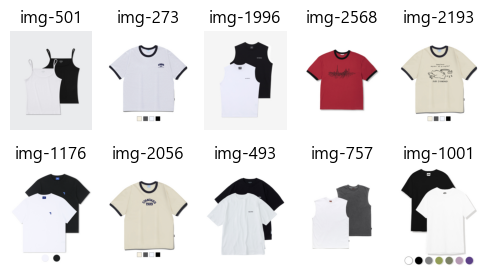

In [107]:
# 유사한 데이터 출력해보기
idx_ref = 8
idx_rec, idx_sim = get_recommender(idx_ref, df, top_n = 10)
# print(idx_rec, idx_sim)
plt.figure(figsize = (2,2))
plt.imshow(cv2.cvtColor(load_image(df.iloc[idx_ref].image), cv2.COLOR_BGR2RGB))

figures = {'img-'+str(i): load_image(row.image) for i, row in df.loc[idx_rec].iterrows()}
plot_figures(figures, 2, 5)

In [47]:
from sklearn.manifold import TSNE
import time
import seaborn as sns

In [209]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(df_embs)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

t-SNE done! Time elapsed: 5.1238250732421875 seconds


<Axes: xlabel='number', ylabel='distance'>

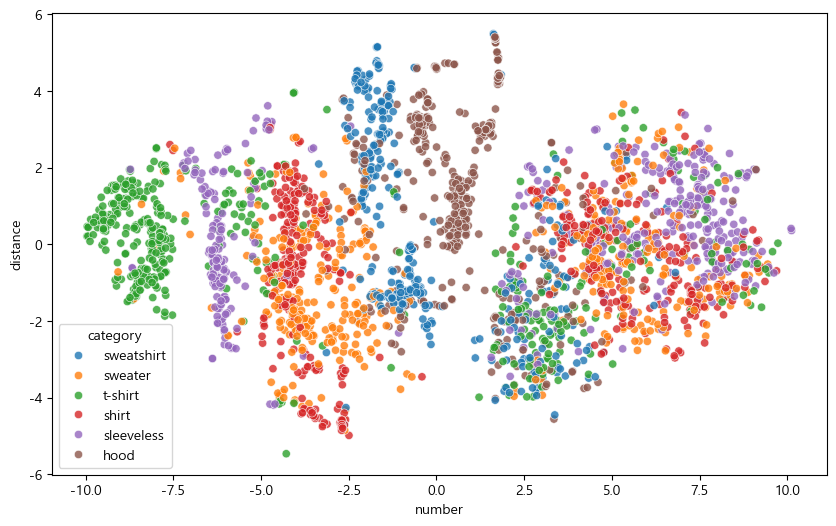

In [210]:
df['number'] = tsne_results[:,0]
df['distance'] = tsne_results[:,1]

plt.figure(figsize=(10,6))
sns.scatterplot(x="number", y="distance", hue="category", data=df, legend="full", alpha=0.8)

1/1 [==============================] - 0s 161ms/step


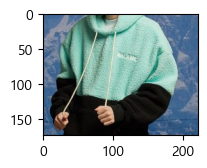

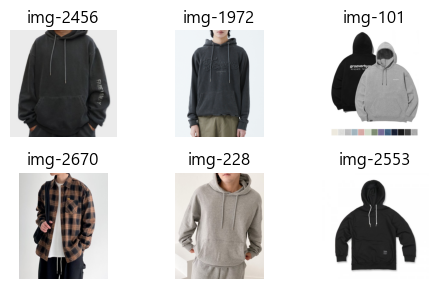

In [123]:
# 테스트 이미지 임베딩
test_img = ".\\test_image\\testt.png"
test_emb = get_embedding(model, test_img)

# 유사한 데이터 찾기
idx_rec_test, idx_sim_test = get_recommender_for_external(test_emb, df, top_n = 6)

# 테스트 이미지 출력
plt.figure(figsize = (2,2))
plt.imshow(cv2.cvtColor(load_image(test_img), cv2.COLOR_BGR2RGB))

# 유사한 이미지 출력
figures = {'img-'+str(i): load_image(row.image) for i, row in df.loc[idx_rec_test].iterrows()}
plot_figures(figures, 2, 3)